In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from datetime import datetime
date_format = '%Y-%m-%d' # This depends on the data
#date_format = '%Y-%m-%d %H:%M:%S'

#from scipy import optimize
from scipy.optimize import minimize
from functools import reduce

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri
from matplotlib import animation
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

from IPython.display import HTML

# Import data

In [2]:
data_directory = r"C:\\Users\\VANDET4\\OneDrive - The Toronto-Dominion Bank\\Desktop\\RiskLab\\"

df = pd.read_csv(data_directory + "dataframe.csv",encoding='utf-8')

df.drop(axis="columns", labels=["Unnamed: 0"], inplace=True)

def to_datetime(date_string):
    if type(date_string) == str:
        return datetime.strptime(date_string,date_format)
    else:
        return date_string

df["Date"] = df["Date"].apply(to_datetime)    
df.set_index("Date",inplace=True)

df.head()

,BXIIU3MC Index,Financials,Energy,Materials,Industrials,Info Tech,Cons. Discretionary,Health Care,Telecom,Cons. Staples,Real Estate,Utilities,US Treasury,US Corportate,US High Yield,CRY Index
Date,,,,,,,,,,,,,,,,
2001-10-09,116.7366,323.74,212.40,119.11,231.76,282.14,205.8304,384.73,186.84,214.63,100.00,161.13,1173.64,1198.19,516.67,154.83
2001-10-10,116.7444,329.30,219.86,122.13,237.77,292.25,212.2388,391.11,188.55,217.03,99.19,163.84,1174.62,1198.94,516.28,155.13
2001-10-11,116.7523,333.50,218.96,126.10,243.57,308.68,219.5457,387.43,185.57,215.23,99.74,164.49,1169.71,1195.26,516.26,156.81
2001-10-12,116.7602,328.67,219.07,125.35,241.63,311.21,216.7271,388.68,183.25,212.67,99.48,163.94,1169.92,1196.89,520.86,153.76
2001-10-15,116.7841,331.49,214.47,124.40,241.74,307.85,216.6667,392.98,181.48,211.87,100.00,162.33,1174.22,1201.24,521.71,151.99


In [4]:
# Make numpy array from values in dataframe
data = df.values

# 1/N

In [3]:
def calc_naive(close_prices):
    num_assets = close_prices.shape[1]
    return np.full(num_assets,1 / num_assets)

# MinVar

In [5]:
# I am embarassingly naive here, I believe this is how you find the variance of a portfolio given weights w
# Not sure whether to use normal returns or log returns
def calc_portfolio_variance(w,close_prices):
    norm_returns = close_prices / close_prices[0]
    log_returns  = np.log(close_prices[1:] / close_prices[:-1])
    return np.matmul(w.T, np.matmul(np.cov(log_returns.T)*252, w))

# This function minimizes the the above function with respect to w, given the numpy array close_prices
# returns the entire optimized result object
# opt.x gives optimal weights, opt.success returns pass/fail for minimization
def calc_MinVar_weights2(close_prices):
    num_assets   = close_prices.shape[1]
    norm_returns = close_prices / close_prices[0]
    log_returns  = np.log(close_prices[1:] / close_prices[:-1])
    
    def con1(x):
        return x.sum() - 1
    
    cons = ({'type': 'eq', 'fun': con1})
    bnds = tuple([(0,1) for _ in range (0,num_assets)])
    init_guess = calc_naive(close_prices)
    
    opt = minimize(calc_portfolio_variance, init_guess, args=(close_prices), constraints=cons, bounds=bnds)
    
    return opt

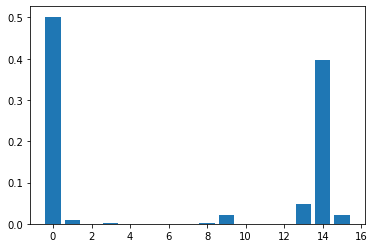

In [7]:
x = np.arange(data.shape[1])
Y = calc_MinVar_weights2(data[0:60,:]).x

fig, ax = plt.subplots()

plt.bar(x, Y)
#plt.xticks(x,df.columns.to_list())
plt.show()

In [8]:
df.columns.to_list()

['BXIIU3MC Index',
 'Financials',
 'Energy',
 'Materials',
 'Industrials',
 'Info Tech',
 'Cons. Discretionary',
 'Health Care',
 'Telecom',
 'Cons. Staples',
 'Real Estate',
 'Utilities',
 'US Treasury',
 'US Corportate',
 'US High Yield',
 'CRY Index']

# ERC

In [14]:

def calc_sigma(prices):
    norm_returns = prices / prices[0]
    sigma = np.cov(norm_returns.T)
    return sigma

def calc_volatility(weights,prices):
    norm_returns = prices / prices[0]
    sigma = np.cov(norm_returns.T)
    volatility = np.sqrt(np.matmul(weights,np.matmul(sigma,weights.T)))
    return volatility

def calc_ERC_weights(close_prices):
    num_assets = close_prices.shape[1]
    
    # Constraints for portfolio weights
    def con1(x):
        return x.sum() - 1
    
    cons = ({'type': 'eq', 'fun': con1})
    bnds = tuple([(0,1) for _ in range (0,num_assets)])
    init_guess = np.full(num_assets,1 / num_assets)
        
    def f(w,close_prices):
        N = len(w)
        vol = calc_volatility(w,close_prices)
        sig = calc_sigma(close_prices)
        r = 0
        for i in range(0,num_assets):
            r = r + (w[i] - (vol**2)/(N*np.matmul(sig,w)[i]))**2
        return r

    opt = minimize(f,init_guess,args=(close_prices),constraints=cons,bounds=bnds)
    if opt.success != True:
        print('fail')
    return opt

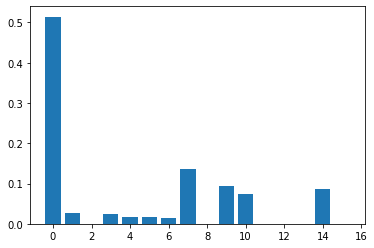

In [15]:
x = np.arange(data.shape[1])
Y = calc_ERC_weights(data[0:60,:]).x

fig, ax = plt.subplots()

plt.bar(x, Y)
#plt.xticks(x,df.columns.to_list())
plt.show()